In [1]:
%matplotlib inline

## Necessary Imports

In [2]:
import os
import posixpath
from urllib.parse import urlencode

import pandas as pd
import requests

## Parameters
___
Set parameters here to match the analysis you'd like to preform.

In [3]:
# Year of 311 complaints to explore
year = 2017
# Number of top comlaints to use in part 1
part_1_top_complaints = 10
# Number of top complaints to use in part 2
part_2_top_complaints = 10
# Number of top zip codes to use in part 2
part_2_top_zips = 10
# Number of top complaints to use in part 2
part_3_top_complaints = 10
# When fetching data, whether or not to bother checking for data locally before hitting the apis
overwrite_311 = False
overwrite_census_zip = False
overwrite_census_borough = False

## Constants
___
Important constants, do not alter if not necessary.

In [4]:
api_url_311 = 'https://data.cityofnewyork.us/resource/fhrw-4uyv.json'
api_url_census_zip = 'https://api.census.gov/data/2010/sf1?get=P0010001&for=zip%20code%20tabulation%20area:*&in=state:36'
api_url_census_borough = 'https://data.cityofnewyork.us/resource/5hae-yeks.json'
api_headers = {'X-App-Token': 'nsmatxqj7NfjKxyB93xrdttB8'}

## Fetching Data

In [5]:
if overwrite_311 or not os.path.isfile('explore311.complaints.csv'):
    # First get the count of records to fetch, as the default is 1000
    count_dict_311 = {'$select': 'count(unique_key)', '$where': f'date_extract_y(created_date) = {str(year)}'}
    count_311 = requests.get(
        posixpath.join(api_url_311, f'?{urlencode(count_dict_311)}'), headers=api_headers).json()[0]['count_unique_key']

    query_dict_311 = {'$select': 'complaint_type, incident_zip, borough', 
                      '$where': f'date_extract_y(created_date) = {str(year)}', '$limit': count_311}
    data_311 = pd.DataFrame(requests.get(
        posixpath.join(api_url_311, f'?{urlencode(query_dict_311)}'), headers=api_headers).json())
    
    # Parse the zip code field using str.extract, a vectorized regex function
    data_311['incident_zip'] = data_311.incident_zip.str.extract(r'(\d{5})', expand=False)
    
    data_311.to_csv('explore311.complaints.csv', index=False)
else:
    data_311 = pd.read_csv('explore311.complaints.csv', dtype=str)

In [6]:
if overwrite_census_zip or not os.path.isfile('explore311.census.zip.csv'):
    
    data_census_zip = pd.DataFrame(requests.get(api_url_census_zip).json())
    
    # The census api returns lists of rows, so some formatting must be done
    data_census_zip = data_census_zip.drop(0).drop(1, axis=1).rename(columns={0: 'population', 2: 'zip'}).set_index('zip')
    
    # It also returns all zip codes within NY. Filter out zips that aren't in the 311 data
    data_census_zip = data_census_zip[data_census_zip.index.isin(data_311.incident_zip)]
    
    data_census_zip['population'] = data_census_zip.population.astype(int)
                               
    data_census_zip.to_csv('explore311.census.zip.csv')
else:
    data_census_zip = pd.read_csv(
        'explore311.census.zip.csv', dtype={'zip': object, 'count_participants': int}).set_index('zip')

In [7]:
if overwrite_census_borough or not os.path.isfile('explore311.census.borough.csv'):
    # First get the count of records to fetch, as the default is 1000
    count_dict_census_borough = {'$select': 'count(borough)'}
    count_census_borough = requests.get(
        posixpath.join(
            api_url_311, f'?{urlencode(count_dict_census_borough)}'), headers=api_headers).json()[0]['count_borough']

    query_dict_census_borough = {'$select': 'borough, sum(_2010_population)', 
                                 '$group': 'borough', '$limit': count_census_borough}
    data_census_borough = pd.DataFrame(requests.get(
        posixpath.join(api_url_census_borough, f'?{urlencode(query_dict_census_borough)}'), 
                       headers=api_headers).json()).set_index('borough')
    
    data_census_borough.to_csv('explore311.census.borough.csv', index=False)
else:
    data_census_borough = pd.read_csv('explore311.census.borough.csv', dtype=str, index_col='borough')

# Part 1
___
_Consider only the 10 most common overall complaint types. For each borough, how many of each of those 10 types were there in 2017?_

### First, let's see what boroughs are included in the data set.

In [8]:
data_311.borough.unique()

array(['BROOKLYN', 'MANHATTAN', 'BRONX', 'QUEENS', 'Unspecified',
       'STATEN ISLAND'], dtype=object)

### We don't care about `Unspecified` as it's not a borough. Filter it out. Also, we'll only need the `complaint_type` and `borough` features for this task, so let's select them.

In [9]:
data_311_1 = data_311[data_311.borough != 'Unspecified'][['complaint_type', 'borough']].copy()

In [10]:
top_complaints_1 = data_311_1.groupby('complaint_type').size().nlargest(part_1_top_complaints)

### Here we can see the top n overall complaints. `Noise - Residential` is the number one complaint across all boroughs.

In [11]:
top_complaints_1

complaint_type
Noise - Residential        229458
HEAT/HOT WATER             213521
Illegal Parking            144828
Blocked Driveway           135059
Street Condition            93222
Street Light Condition      82799
UNSANITARY CONDITION        79282
Noise - Street/Sidewalk     72868
Water System                65096
Noise                       60168
dtype: int64

### Now, let's filter out all the data that doesn't fit into those top n categories, then group the data by borough. Once that's done, on each borough, we group by complaint type. As we've already filtered out the complaints not in the top n, we just have to get the size of each complaint group and return it to see the numbers of complaints by complaint type by borough.

In [12]:
borough_counts = data_311_1[data_311_1.complaint_type.isin(top_complaints_1.index)].groupby('borough')\
    .apply(lambda borough: borough.groupby('complaint_type').size())

In [13]:
borough_counts

complaint_type,Blocked Driveway,HEAT/HOT WATER,Illegal Parking,Noise,Noise - Residential,Noise - Street/Sidewalk,Street Condition,Street Light Condition,UNSANITARY CONDITION,Water System
borough,,,,,,,,,,
BRONX,24574,68718,16122,3134,57663,14025,11761,18410,24561,10217
BROOKLYN,49302,66984,55380,15421,67629,21313,25432,22458,26659,19809
MANHATTAN,3428,46529,19687,29002,51026,29147,14840,11077,14635,10929
QUEENS,54290,29217,46065,10685,46396,7530,30629,24258,11474,18792
STATEN ISLAND,3465,2073,7574,1926,6744,853,10560,6596,1953,5349


### A stacked bar chart will make it easier to see how each borough ranks in complaints and how the complaint types rank within each borough.

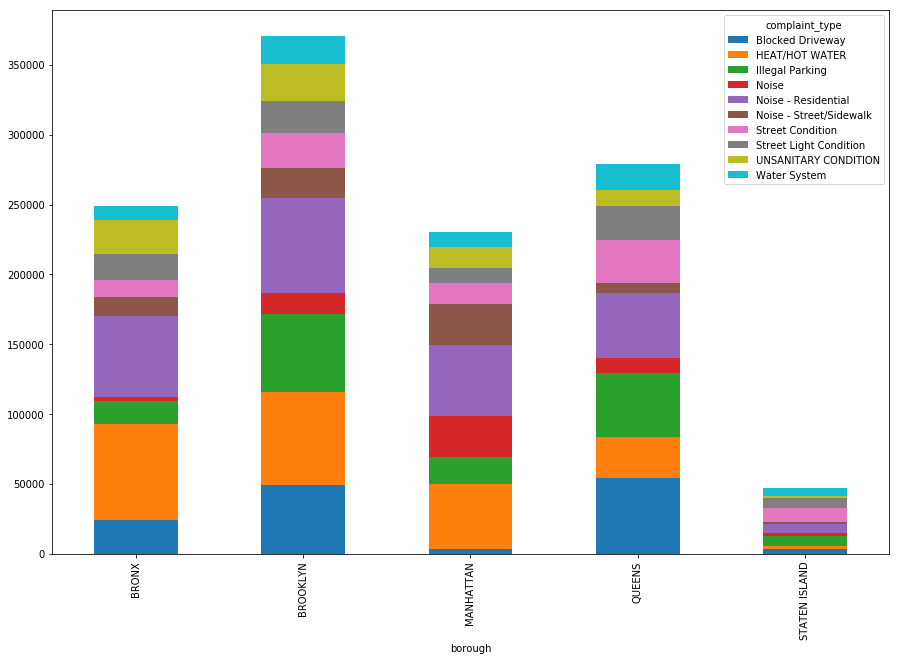

In [14]:
borough_counts.plot.bar(stacked=True, figsize=(15, 10))

In [15]:
del data_311_1, top_complaints_1, borough_counts

# Part 2
___
_Consider only the 10 most common overall complaint types.  For the 10 most populous zip codes, how many of each of those 10 types were there in 2017?_

### For this part, we only need `complaint_type` and `incident_zip` to complete the analysis.

In [16]:
data_311_2 = data_311[['complaint_type', 'incident_zip']].copy()

In [17]:
top_complaints_2 = data_311_2.groupby('complaint_type').size().nlargest(part_2_top_complaints)

In [18]:
top_complaints_2

complaint_type
Noise - Residential        230152
HEAT/HOT WATER             213521
Illegal Parking            146122
Blocked Driveway           136097
Street Condition            93265
Street Light Condition      84195
UNSANITARY CONDITION        79282
Noise - Street/Sidewalk     73085
Water System                65096
Noise                       60171
dtype: int64

### Just to check we've got the right population data

In [19]:
# Should be about 8.5 million
data_census_zip.population.sum()

11725799

In [20]:
top_zips = data_census_zip.nlargest(part_2_top_zips, 'population')

### Cross-referencing with http://www.city-data.com/zipmaps/New-York-New-York.html, these numbers look to be correct.

In [21]:
top_zips

,population
zip,
11368,109931
11226,101572
11373,100820
11220,99598
11385,98592
10467,97060
10025,94600
11208,94469
11236,93877


### Now we can do the same as before, grouping into top `zips`, then into `complaint_type`.

In [22]:
top_zips_counts = data_311_2[
    data_311_2.complaint_type.isin(top_complaints_2.index) & data_311_2.incident_zip.isin(top_zips.index)]\
    .groupby('incident_zip').apply(lambda zip: zip.groupby('complaint_type').size())

In [23]:
top_zips_counts

complaint_type,Blocked Driveway,HEAT/HOT WATER,Illegal Parking,Noise,Noise - Residential,Noise - Street/Sidewalk,Street Condition,Street Light Condition,UNSANITARY CONDITION,Water System
incident_zip,,,,,,,,,,
10025,125,2397,736,1398,2085,1224,628,21,714,481
10467,2068,6041,986,285,5807,713,612,407,2192,560
11207,2062,2461,1500,199,3061,558,1142,932,1621,757
11208,2756,2052,2150,188,2795,825,816,566,1341,710
11220,1558,1634,2013,442,1522,498,690,610,719,674
11226,2203,7569,1076,440,4854,1831,491,202,3155,406
11236,3041,1145,1431,108,1929,201,1021,180,562,623
11368,4384,1620,1251,158,2460,684,561,444,639,617
11373,2635,3408,1277,270,1842,304,691,362,756,372


### Here we plot the data as we did before, except here, we select the data with the index of `top_zips`. This orders the data from left to right by zip code population. 
___
Interestingly, the most populous zip code only creates the sixth most complaints of the top ten.

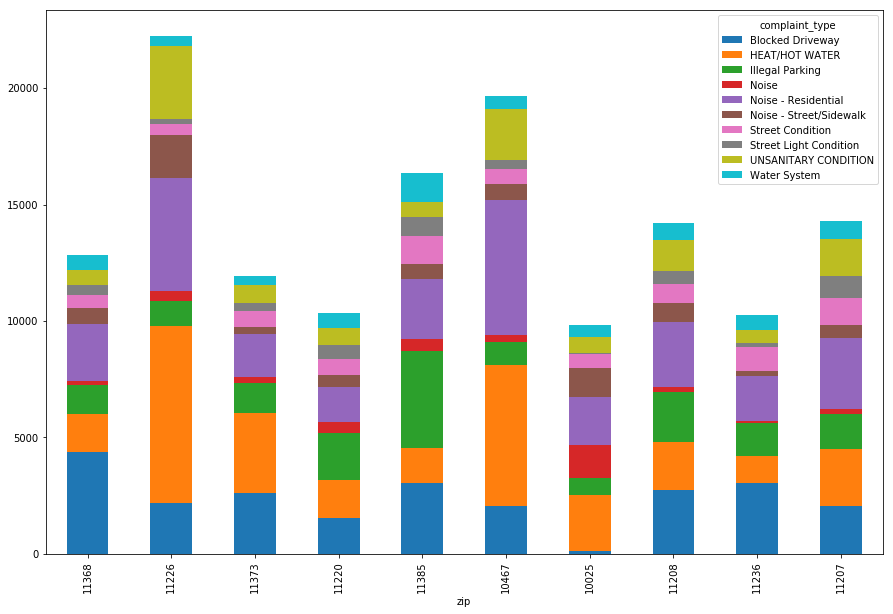

In [24]:
top_zips_counts.loc[top_zips.index].plot.bar(stacked=True, figsize=(15, 10))

In [25]:
del data_311_2, top_complaints_2, data_census_zip, top_zips, top_zips_counts

# Part 3
___
_Considering all complaint types. Which boroughs are the biggest "complainers" relative to the size of the population in 2017? Meaning, calculate a complaint-index that adjusts for population of the borough._

### As in part 1, we first need to filter out the 'Unspecified' borough.

In [26]:
data_311_3 = data_311[data_311.borough != 'Unspecified'][['complaint_type', 'borough']].copy()

### We group the data by borough, then get the amount of complaints from each.

In [27]:
borough_complaints = data_311_3.groupby('borough').size()
borough_complaints.name = 'Complaints'
borough_complaints.index = borough_complaints.index.str.title()

### We combine the data to do some neat things with plotting later

In [28]:
combined_data = data_census_borough.rename(
    columns={'sum_2010_population': '2010 Population'}).join(borough_complaints).astype(int)

### In the left pie chart, we see the population distribution of all the boroughs, and on the righ, we see the breakdown of all complaints by borough.
___
This makes good sense, the most populous zip codes make the most complaints.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f659011da20>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f6590101fd0>], dtype=object)

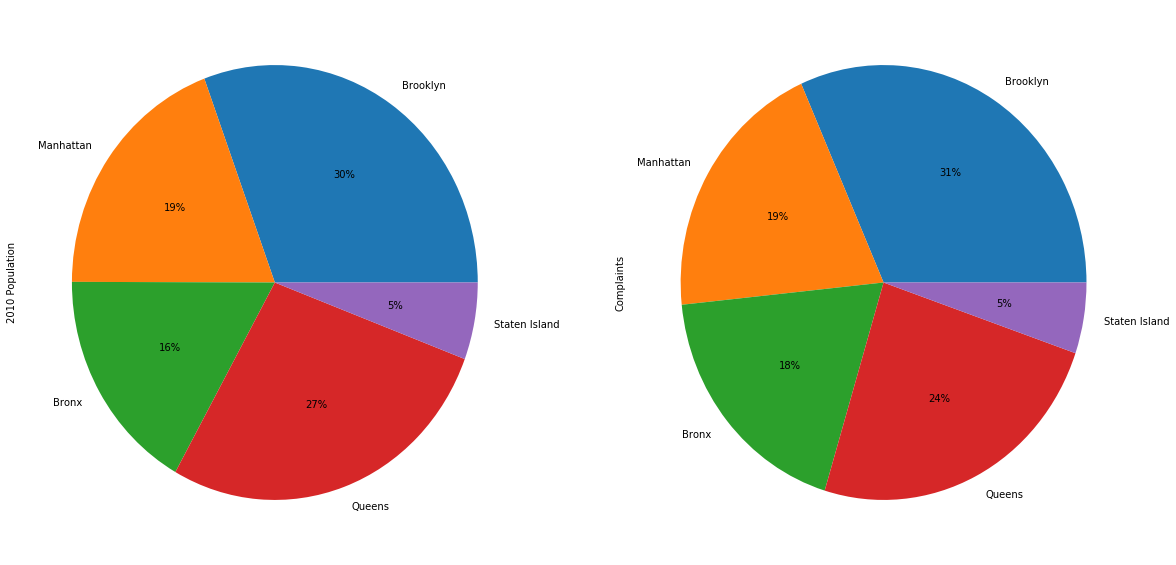

In [29]:
combined_data.plot.pie(figsize=(20, 10), autopct='%d%%', subplots=True, legend=False)

### Here, we've divided the amount of complaints in a borough by that borough's population. This gives a complaint per person number.
___
This number represents how 'complainy' the average person is in each borough. As there are five boroughs, if each borough was generating the same number of per person, since there are five boroughs, we'd expect each borough to be generating 1/5 or 20% of the complaints per person. As it stands, Manhattan and Brooklyn residents are around the average 'complainyness', Staten Island and Brooklyn fall below the average, and The Bronx's residents are a little extra cranky.

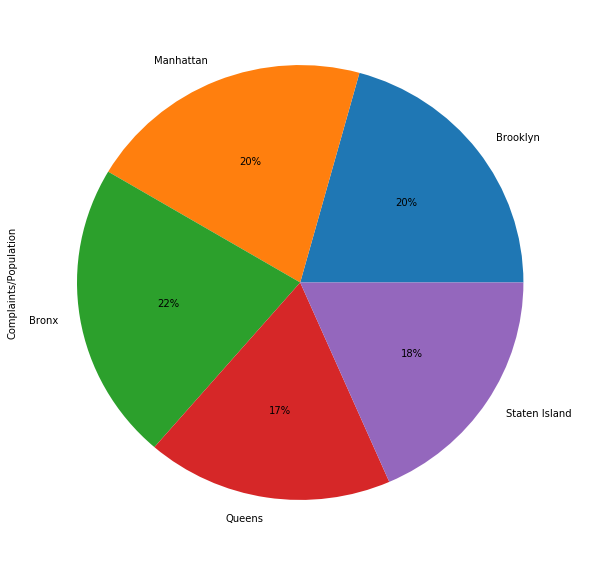

In [30]:
(combined_data.Complaints/combined_data['2010 Population']).rename('Complaints/Population')\
    .plot.pie(figsize=(10, 10), autopct='%d%%')

### Another interesting study is to see how each borough stacks up in terms of complaints per complaint type per person. It's almost the same as the last analysis, except we first get the n greatest complaint types, as to not get overloaded with information, then group on `borough` and `complaint_type`.

In [31]:
top_complaints_3 = data_311_3.groupby('complaint_type').size().nlargest(part_3_top_complaints)

In [32]:
borough_complaint_type = data_311_3[data_311_3.complaint_type.isin(top_complaints_3.index)]\
    .groupby(['borough', 'complaint_type']).size().unstack()
borough_complaint_type.name = 'Complaints'
borough_complaint_type.index = borough_complaint_type.index.str.title()

### Here we can see that the different boroughs differ radically in what bothers them the most.
___
Obviously Manhattan doesn't have many `Blocked Driveways`, and equally unsurprising is that they generate almost half of the `Noise` complaints. What is interesting is that both Brooklyn and Queens seem to have similar complaint numbers in many of the categories. They are very similar boroughs it would appear.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f65791dc390>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f65724df438>]], dtype=object)

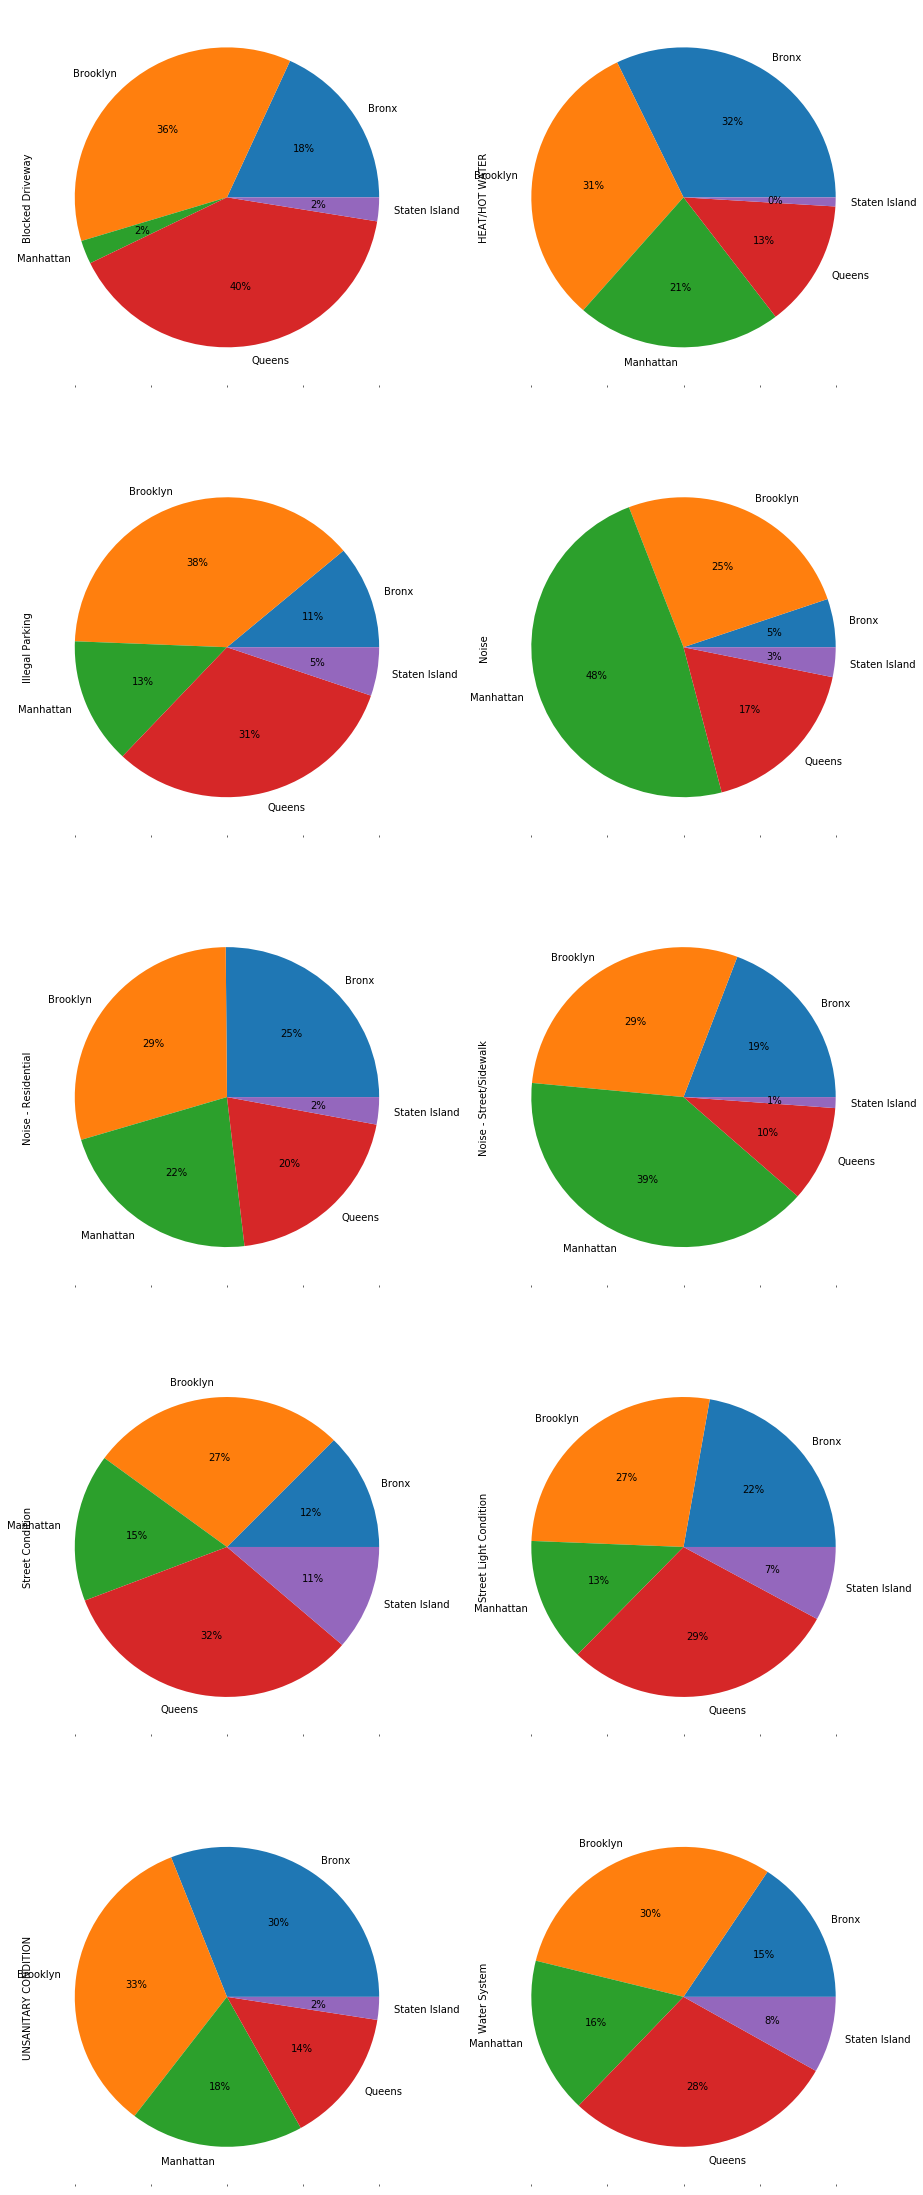

In [33]:
borough_complaint_type.plot.pie(autopct='%d%%', subplots=True, legend=False, 
                                layout=(int(part_3_top_complaints/2), 2), figsize=(15, 40))

In [34]:
combined_data_type = data_census_borough.rename(
    columns={'sum_2010_population': '2010 Population'}).join(borough_complaint_type).astype(int)

### Once we correct for population, things get really interesting.
___
Here we can see that The Bronx has a large share of the `Heat/Hot Water` complaints per person. They are the borough furthest North, after all. Manhattan has tipped the scales and actually generates more than half of the `Noise` complaints per person. Probably because of all the cars. Next, we see that Queens residents have a big problem with `Blocked Driveways`. If I had a driveway, I'd be really protective of it too. Brooklyn has almost as many `Blocked Driveway` complaints per person, and more `Illegal Parking` complaints per person. It really is impossible to park in Brooklyn. Finally Staten Island apparently has some bad `Street Condition`. After all, it is built on top of a landfill. That produces a lot of methane, which I imagine is seeping through the streets and breaking it up along the way.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f656a841a90>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f6565a2f588>]], dtype=object)

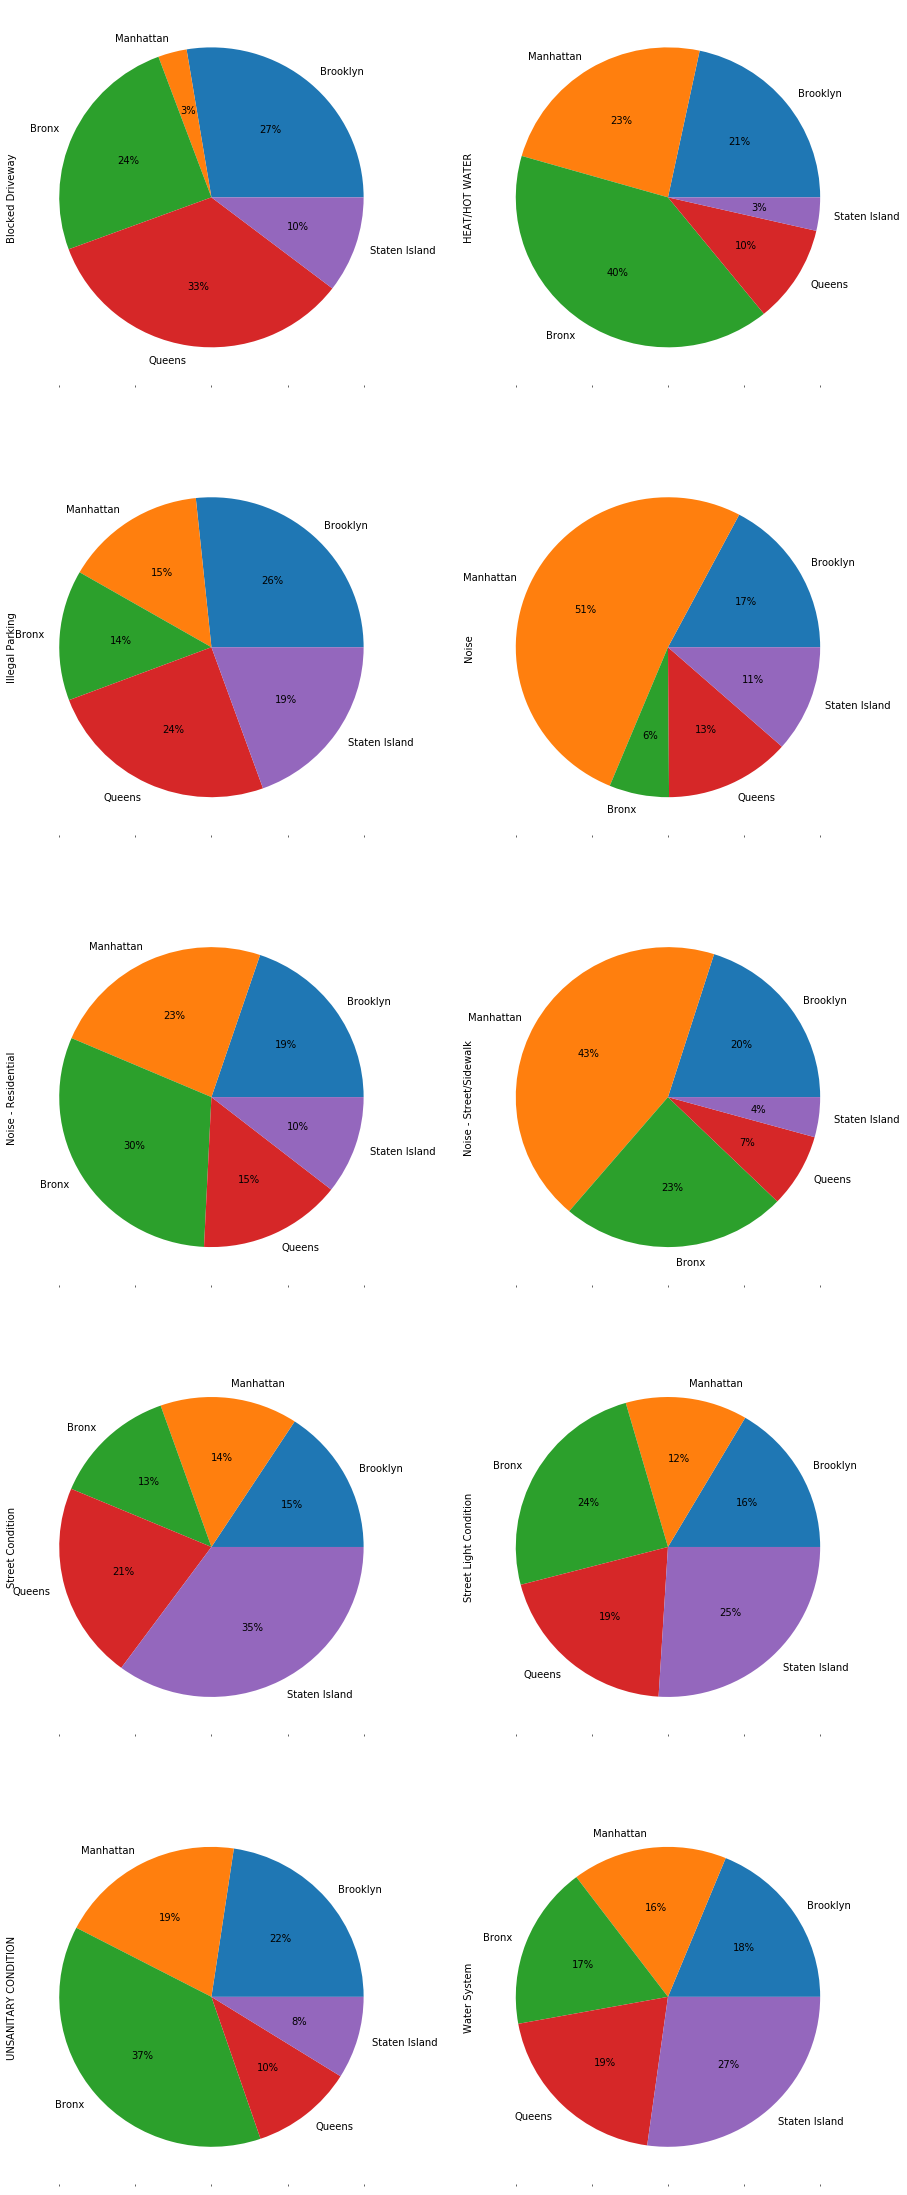

In [35]:
# Have to multiply the data by 1000 because of a weird quirk with the pie plot, if the sum of the data < 1,
# then it shows absolute values. Multiplying by 1000 fixes this, and doesn't affect the ratios.
(combined_data_type.div(combined_data_type['2010 Population'], axis=0).drop('2010 Population', axis=1)*1000)\
    .plot.pie(autopct='%d%%', subplots=True, legend=False, layout=(int(part_3_top_complaints/2), 2), figsize=(15, 40))